<h3 style="text-align: center;"><b>FashionMNIST (5 баллов)</b></h3>

Для обучения нейросетей на TensorFlow обычно используют либо модуль `.keras` (который, по сути, является Keras'ом, только обращение к нему происходит через TF), либо модуль `tf.Slim`. В этом задании Вам нужно самостоятельно написть обучение нейросети на датасете FashionMNIST и добиться качества (поклассового `accuracy`) **больше, чем 0.9**.

Бейзланом к этому заданию является официальный туториал TensorFlow: https://www.tensorflow.org/tutorials/keras/basic_classification

*Hint*: можно использовать свёрточные слои и слои не из туториала

In [1]:
import tensorflow as tf
import numpy as np

In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist

train_data, test_data = fashion_mnist.load_data()

train_data = list(train_data)
train_data[0] = train_data[0]
train_data[1] = train_data[1]

test_data = list(test_data)

In [3]:
std = train_data[0].std()
mean = train_data[0].mean()


train_data[0] = (train_data[0] - mean) / std
test_data[0] = (test_data[0] - mean) / std

In [4]:
image = tf.placeholder(tf.float32, shape=[None, 28, 28])
labels = tf.placeholder(tf.int64, shape=[None])
labels_one_hot = tf.one_hot(labels, depth=10)

flattened = tf.layers.flatten(image)
output = tf.layers.dense(flattened, units=10, activation='softmax')

loss = tf.losses.softmax_cross_entropy(labels_one_hot, output)
accuracy, accuracy_op = tf.metrics.accuracy(labels=tf.argmax(labels_one_hot, 1), 
                                            predictions=tf.argmax(output, 1))

my_accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(output, 1), labels), tf.float32))

optimizer = tf.train.RMSPropOptimizer(0.001)
train = optimizer.minimize(loss)

W0709 16:00:22.354820   104 deprecation.py:323] From <ipython-input-4-f701cacd992d>:5: flatten (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.flatten instead.
W0709 16:00:22.567648   104 deprecation.py:323] From <ipython-input-4-f701cacd992d>:6: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.
W0709 16:00:22.571643   104 deprecation.py:506] From C:\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0709 16:00:22.979649   104 deprecation.py:323] From C:\Anaconda3\lib\site-packages\tensorflow\python\ops\losses\losses_impl.py:1

In [5]:
tf.trainable_variables()

[<tf.Variable 'dense/kernel:0' shape=(784, 10) dtype=float32_ref>,
 <tf.Variable 'dense/bias:0' shape=(10,) dtype=float32_ref>]

In [6]:
def dataset_generator(dataset, batch_size=128):
    i = 0
    while True:
        yield {
                'data': dataset[0][i * batch_size:(i + 1) * batch_size],
                'labels': dataset[1][i * batch_size:(i + 1) * batch_size] 
              }
        i += 1
        if i * batch_size >= len(dataset[0]):
            i = 0

In [7]:
from tqdm import tqdm_notebook
with tf.device('/gpu:0'):
    sess = tf.Session()
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())

    writer = tf.summary.FileWriter('.', sess.graph)

    train_generator = dataset_generator(train_data)
    test_generator = dataset_generator(test_data)
    history = {'loss': [],
               'val_loss': [],
               'accuracy': [],
               'val_accuracy': []}

    for i in tqdm_notebook(range(5000)):
        train_batch = next(train_generator)
        test_batch = next(test_generator)

        _, train_accuracy, train_loss = sess.run((train, my_accuracy, loss), 
                                             feed_dict={image: train_batch['data'], 
                                                        labels: train_batch['labels']})


        val_accuracy, val_loss = sess.run((my_accuracy, loss), feed_dict={image: test_batch['data'], 
                                                                          labels: test_batch['labels']})

        history['loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['accuracy'].append(train_accuracy)
        history['val_accuracy'].append(val_accuracy)

In [8]:
def smoothen_curve(points, factor=51):
    from scipy.signal import savgol_filter
    return savgol_filter(points, factor, 3) 

C:\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


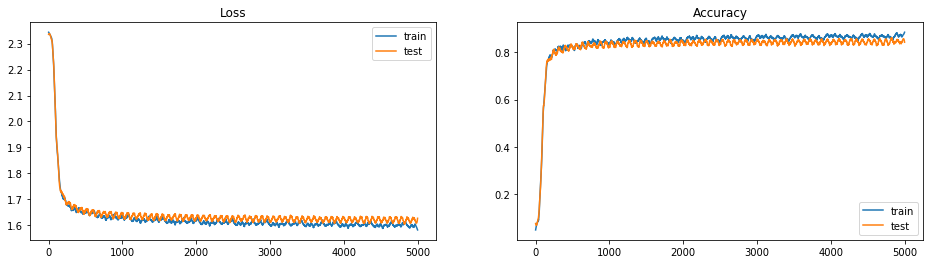

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(np.arange(len(history['loss'])), smoothen_curve(history['loss']), label='train')
ax1.plot(np.arange(len(history['val_loss'])), smoothen_curve(history['val_loss']), label='test')
ax1.legend()
ax1.set_title('Loss')

ax2.plot(np.arange(len(history['accuracy'])), smoothen_curve(history['accuracy']), label='train')
ax2.plot(np.arange(len(history['val_accuracy'])), smoothen_curve(history['val_accuracy']), label='test')
ax2.set_title('Accuracy')
ax2.legend()

In [10]:
validation_generator = dataset_generator(test_data, 1)
s = 0
for i in range(len(test_data[0])):
    batch = next(validation_generator)
    s += sess.run(my_accuracy, feed_dict={
            image: batch['data'],
            labels: batch['labels']
        })
print(s / len(test_data[0]))

0.8433


#### CIFAR10:
Бейзлайн по классификации CIFAR10: https://www.tensorflow.org/tutorials/images/deep_cnn  
Там есть ссылки на файлы с кодом, который тоже можно прямо сюда вставлять, главное, чтобы качество в итоге получилось хорошим (формально порог не задан, будет смотреться у всех индивиуально).

In [11]:
<Покажите класс>

SyntaxError: invalid syntax (<ipython-input-11-cca336a18f27>, line 1)

In [ ]:
...